<a href="https://colab.research.google.com/github/huntrese/Sigmoid-Exam/blob/main/ExamSigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports

Installing crucio for Class Balancing and shap for model interpretaion

In [112]:
!pip install crucio -q
!pip install shap -q
!pip install imperio -q
!pip install xgboost -q
!pip install kydavra -q


importing all necessary modules

In [113]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from crucio import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from imperio import BoxCoxTransformer
from xgboost import XGBClassifier


# loading the dataset

In [114]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [147]:
df=pd.read_csv("/content/gdrive/MyDrive/data.csv")
df.head()

,Rank,Company,Ticker,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs,Change_in_Rank,...,Assets_M,CEO,Country,HeadquartersCity,HeadquartersState,Website,CompanyType,Footnote,MarketCap_Updated_M,Updated
0,1,Walmart,WMT,Retailing,General Merchandisers,yes,no,no,no,0.0,...,243197,C. Douglas McMillon,U.S.,Bentonville,AR,www.stock.walmart.com,Public,"Figures are for fiscal year ended Jan. 31, 202...",416986.0,2023-08-02
1,2,Amazon,AMZN,Retailing,Internet Services and Retailing,no,no,no,no,0.0,...,462675,Andrew R. Jassy,U.S.,Seattle,WA,www.amazon.com,Public,"Market value as of July 17, 2023.",1370373.0,2023-08-02
2,3,Exxon Mobil,XOM,Energy,Petroleum Refining,yes,no,no,no,3.0,...,369067,Darren W. Woods,U.S.,Irving,TX,www.exxonmobil.com,Public,Excise taxes have been deducted. Market value ...,409878.0,2023-08-02
3,4,Apple,AAPL,Technology,"Computers, Office Equipment",yes,no,no,yes,-1.0,...,352755,Timothy D. Cook,U.S.,Cupertino,CA,www.apple.com,Public,"Figures are for fiscal year ended Sept. 30, 20...",3051211.0,2023-08-02
4,5,UnitedHealth Group,UNH,Health Care,Health Care: Insurance and Managed Care,yes,no,no,yes,0.0,...,245705,Andrew P. Witty,U.S.,Minnetonka,MN,www.unitedhealthgroup.com,Public,"Market value as of July 17, 2023.",450694.0,2023-08-02


# PreProcessing

initial analysis of the dataset, we see a lot of columns with missing values and strings

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank                        1000 non-null   int64  
 1   Company                     1000 non-null   object 
 2   Ticker                      959 non-null    object 
 3   Sector                      1000 non-null   object 
 4   Industry                    1000 non-null   object 
 5   Profitable                  1000 non-null   object 
 6   Founder_is_CEO              1000 non-null   object 
 7   FemaleCEO                   1000 non-null   object 
 8   Growth_in_Jobs              993 non-null    object 
 9   Change_in_Rank              929 non-null    float64
 10  Gained_in_Rank              929 non-null    object 
 11  Dropped_in_Rank             929 non-null    object 
 12  Newcomer_to_the_Fortune500  500 non-null    object 
 13  Global500                   1000 n

checked correlation of the most eye catching columns, to get an initial understanding of the realtionship between features

In [149]:
columns=['Rank', 'MarketCap_Updated_M', 'ProfitsPercentChange']
alt.Chart(df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=columns[::-1],
    column=columns
).interactive()

alt.RepeatChart(...)

based on these plots, we can see that there is little useful correlation between the rank of the company, its MarketCap and the ProfitsPercentChange

Dropped Footnote and checked value counts to see what data is in each collumn, it is a little bit dirty, but very usefull

In [150]:
for i in df.drop(["Footnote"],axis=1):
  if df[i].dtype=="object":
    print(df[i].value_counts())

Walmart                       1
Weis Markets                  1
Patrick Industries            1
Hologic                       1
Snap-on                       1
                             ..
Regeneron Pharmaceuticals     1
Liberty Media                 1
APA                           1
Qurate Retail                 1
Alliance Resource Partners    1
Name: Company, Length: 1000, dtype: int64
WMT     1
VAC     1
CTLT    1
EPAM    1
FLO     1
       ..
ADI     1
R       1
CAR     1
UNM     1
ARLP    1
Name: Ticker, Length: 959, dtype: int64
Financials                       161
Technology                       117
Energy                           115
Health Care                       80
Retailing                         72
Business Services                 52
Industrials                       49
Materials                         48
Transportation                    39
Food, Beverages & Tobacco         33
Wholesalers                       31
Engineering & Construction        31
Chemicals   



*   probably target imputation for Sector,Industry,City,State
*   Class balancing might be an issue
*   Founder is ceo,FemaleCEO very unbalanced 1:10
*   Growth in jobs,Global500 unbalanced 1:3,1:4
*   Newcomer,bestCompanies,companyType very unbalanced 1:20







did the reverse of df.info(), wanted to see the number of nans more easily

## missing values

In [151]:
for i in df:
  print(i,pd.isna(df[i]).sum(),df[i].dtype)

Rank 0 int64
Company 0 object
Ticker 41 object
Sector 0 object
Industry 0 object
Profitable 0 object
Founder_is_CEO 0 object
FemaleCEO 0 object
Growth_in_Jobs 7 object
Change_in_Rank 71 float64
Gained_in_Rank 71 object
Dropped_in_Rank 71 object
Newcomer_to_the_Fortune500 500 object
Global500 0 object
Best_Companies 0 object
Number_of_employees 0 int64
MarketCap_March31_M 41 float64
Revenues_M 0 int64
RevenuePercentChange 9 float64
Profits_M 0 int64
ProfitsPercentChange 134 float64
Assets_M 0 int64
CEO 1 object
Country 0 object
HeadquartersCity 0 object
HeadquartersState 0 object
Website 0 object
CompanyType 0 object
Footnote 9 object
MarketCap_Updated_M 35 float64
Updated 0 object


Also created a plot to visualise where the nans are, obviously half of newcomer to global 500 is empty since there are 500 spots but 1000 companies

<Axes: >

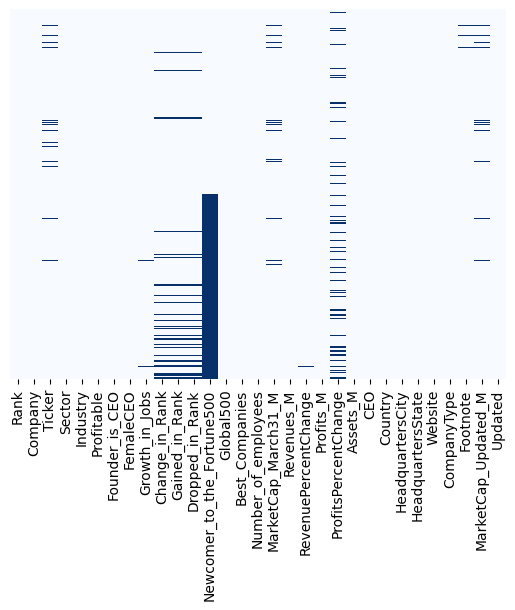

In [152]:

sns.heatmap(df[df.columns].isnull(),cmap='Blues',yticklabels=False,cbar=False)

dropped the columns that provided little information for the model(Company ticker website and CEO means basically nothing to whether a company is profitable or not).
saved companyDetails just in case

## dropping collumns

In [153]:
companyDetails=df[df.columns[1:3]]
df.drop(["Company","Ticker","CEO","Country","Website","Footnote"],axis=1,inplace=True)
companyDetails

,Company,Ticker
0,Walmart,WMT
1,Amazon,AMZN
2,Exxon Mobil,XOM
3,Apple,AAPL
4,UnitedHealth Group,UNH
...,...,...
995,TTEC Holdings,TTEC
996,ProFrac Holding,ACDC
997,Summit Materials,SUM
998,Teladoc Health,TDOC


##Label Encoder

transformed all binary features into their numerical variant

In [154]:
for i in ["Profitable","Founder_is_CEO","FemaleCEO","Dropped_in_Rank","Gained_in_Rank","Newcomer_to_the_Fortune500","Global500","Growth_in_Jobs","Best_Companies","CompanyType","Updated"]:
  df[i]=LabelEncoder().fit_transform(df[i])

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank                        1000 non-null   int64  
 1   Sector                      1000 non-null   object 
 2   Industry                    1000 non-null   object 
 3   Profitable                  1000 non-null   int64  
 4   Founder_is_CEO              1000 non-null   int64  
 5   FemaleCEO                   1000 non-null   int64  
 6   Growth_in_Jobs              1000 non-null   int64  
 7   Change_in_Rank              929 non-null    float64
 8   Gained_in_Rank              1000 non-null   int64  
 9   Dropped_in_Rank             1000 non-null   int64  
 10  Newcomer_to_the_Fortune500  1000 non-null   int64  
 11  Global500                   1000 non-null   int64  
 12  Best_Companies              1000 non-null   int64  
 13  Number_of_employees         1000 n

#Self made SimpleImputer

tried to use target imputation for the following collumns, once again I failed,so I made do with Half of the job (SimpleImputer).
to give some details, the difference between this and targetimputer that I did manage to get is for 95% of the data multiplying by 100(0.82-82,0.55-55,0.76-76), So I didnt bother adding it back

In [156]:
for i in ["Sector","Industry","HeadquartersCity","HeadquartersState"]:
  target_mean = df.groupby(i)['Profitable'].mean()


  df[i] = df[i].map(target_mean)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank                        1000 non-null   int64  
 1   Sector                      1000 non-null   float64
 2   Industry                    1000 non-null   float64
 3   Profitable                  1000 non-null   int64  
 4   Founder_is_CEO              1000 non-null   int64  
 5   FemaleCEO                   1000 non-null   int64  
 6   Growth_in_Jobs              1000 non-null   int64  
 7   Change_in_Rank              929 non-null    float64
 8   Gained_in_Rank              1000 non-null   int64  
 9   Dropped_in_Rank             1000 non-null   int64  
 10  Newcomer_to_the_Fortune500  1000 non-null   int64  
 11  Global500                   1000 non-null   int64  
 12  Best_Companies              1000 non-null   int64  
 13  Number_of_employees         1000 n

##plotting relationships between data

In [157]:
columns=list(set(df.columns)-(set(["Founder_is_CEO","FemaleCEO","Dropped_in_Rank","Gained_in_Rank","Newcomer_to_the_Fortune500","Global500","Growth_in_Jobs","Best_Companies","CompanyType","Profitable","Sector","Industry","HeadquartersCity","HeadquartersState"])))
print(columns)
alt.Chart(df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='Profitable'
).properties(
    width=150,
    height=150
).repeat(
    row=columns[::-1],
    column=columns[::-1]
)

['Change_in_Rank', 'Rank', 'MarketCap_March31_M', 'RevenuePercentChange', 'Revenues_M', 'MarketCap_Updated_M', 'Profits_M', 'Number_of_employees', 'Assets_M', 'ProfitsPercentChange', 'Updated']


alt.RepeatChart(...)

yes this is a lot of information in a very small plot, but unless i want it in a very long list this is the best option.

some insights we can gather from these plots is that:
companies with high marketcap do not fluctuate much in rank,

Number of employees doesnt really affect anything,

we can see some clear separation of the data

##KNNImputer

used KNNImputer to impute all the nans in the numeric columns, tried mice, but there was no point since I have like 30 nans

In [158]:
imputer=KNNImputer(n_neighbors=3)
for i in ["Change_in_Rank","MarketCap_March31_M","RevenuePercentChange","ProfitsPercentChange","MarketCap_Updated_M"]:
  df[i]=imputer.fit_transform(df[i].values.reshape(-1,1))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank                        1000 non-null   int64  
 1   Sector                      1000 non-null   float64
 2   Industry                    1000 non-null   float64
 3   Profitable                  1000 non-null   int64  
 4   Founder_is_CEO              1000 non-null   int64  
 5   FemaleCEO                   1000 non-null   int64  
 6   Growth_in_Jobs              1000 non-null   int64  
 7   Change_in_Rank              1000 non-null   float64
 8   Gained_in_Rank              1000 non-null   int64  
 9   Dropped_in_Rank             1000 non-null   int64  
 10  Newcomer_to_the_Fortune500  1000 non-null   int64  
 11  Global500                   1000 non-null   int64  
 12  Best_Companies              1000 non-null   int64  
 13  Number_of_employees         1000 n

##corr matrix

checked the correlation of columns between each other, mostly cared about Profitable

<Axes: >

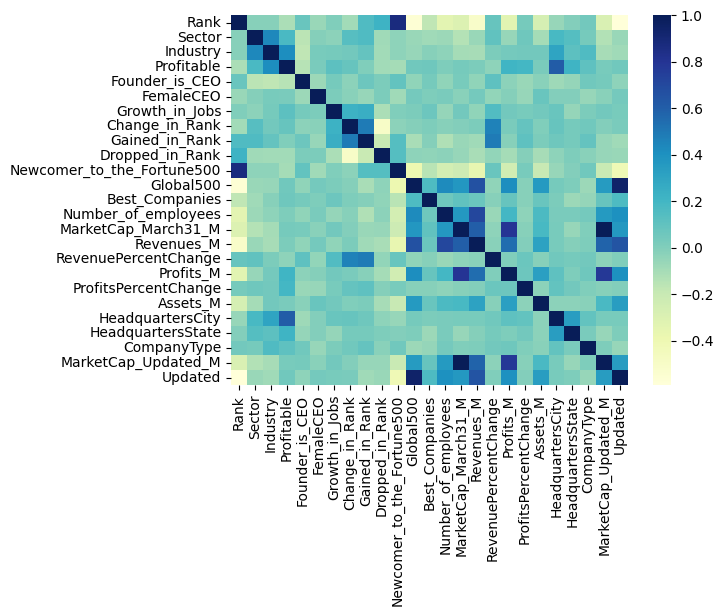

In [159]:
sns.heatmap(df.corr(), cmap="YlGnBu")

##Class Balancing

wanted to do some oversampling for the unbalanced columns, aftter 3 hours I gave up.

In [160]:
try:
  smote= SMOTE()
  smote.balance(df.values,target="Profitable")
except:
  print("Error, sorry couldnt fix")

Error, sorry couldnt fix


##ConfusionMatrix

created a function that would help visualise the model results though a confussion matrix

In [161]:
def cMatrix():
  cm=confusion_matrix(y_test,y_pred)
  plt.figure(figsize=(10,6))
  sns.heatmap(cm,annot=True)
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.show()
  print(recall_score(y_test, y_pred, average='macro'))

created a basic pipeline with standardscaler and logistic regression

#Model Heaven

In [162]:
pipe1=Pipeline([
              ("Std Scaler", StandardScaler()),
             ("Lineqar Regression", LogisticRegression()),

             ])

trained the model and checked its accuracy, we got a very high 90%, which is both good and strange since barely anything was done to preprocess the data

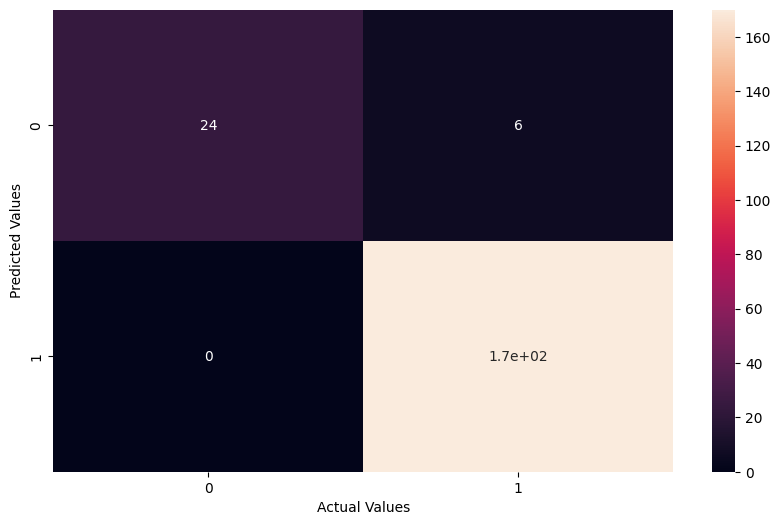

0.9


In [163]:
X=df.drop(["Profitable"],axis=1)
y=df.Profitable
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.2)


pipe1.fit(X_train,y_train)
pipe1.score(X_train,y_train)
pipe1.score(X_test,y_test)
y_pred=pipe1.predict(X_test)
cMatrix()

##Outlier Detection

did some outlier detection and used another scaler this time

In [164]:
isol=IsolationForest()
df_clean=df.copy()
df_clean["outlier"]=pd.Series(isol.fit_predict(df_clean.values))
df_clean=df_clean[df_clean.outlier!=-1]
df_clean.drop("outlier",axis=1,inplace=True)

X=df_clean.drop(["Profitable"],axis=1)
y=df_clean.Profitable
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.2)


In [165]:
pipe1=Pipeline([
              ("MinMax Scaler", MinMaxScaler()),
             ("Lineqar Regression", LogisticRegression()),

             ])

We get an accuracy of 67%, which is a great deal worse than the original simple implementation with great results

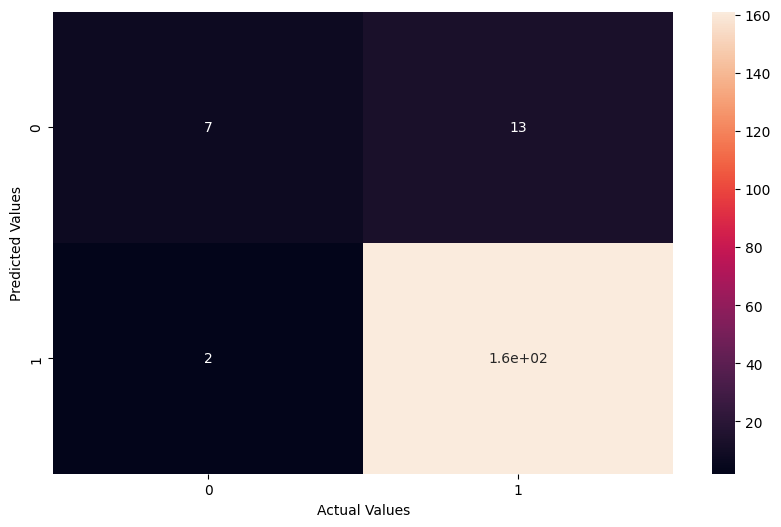

0.6688650306748466


In [166]:

pipe1.fit(X_train,y_train)
pipe1.score(X_train,y_train)
pipe1.score(X_test,y_test)
y_pred=pipe1.predict(X_test)
cMatrix()

Thought that Isolation forest made the model worse, decided to try not using scalers at all

In [167]:
pipe1=Pipeline([
             ("Logistic Regression", LogisticRegression()),
             ])

we get a very high accuracy of 97.5%, very interesting

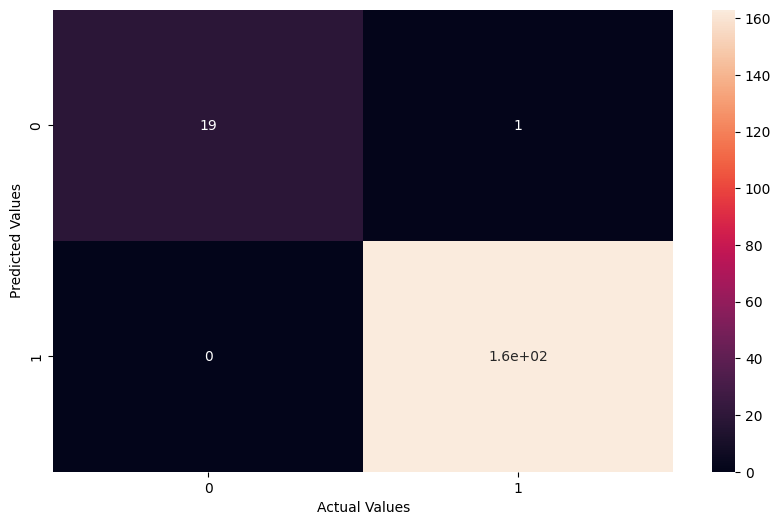

0.975


In [168]:
pipe1.fit(X_train,y_train)
pipe1.score(X_train,y_train)
pipe1.score(X_test,y_test)
y_pred=pipe1.predict(X_test)
cMatrix()

thought I would give PCA a try and see if it would be of any help, apparently there there is a chance that PCA would be useful

##PCA

In [169]:
li=[]
lr=LogisticRegression()

for i in range(1, X.shape[1]):
  pc=PCA(i).fit(X)
  X_pc=pc.transform(X)
  X_train, X_test, y_train, y_test=train_test_split(X_pc, y, test_size=0.2, random_state=19)
  lr.fit(X_train, y_train)
  li.append(lr.score(X_test, y_test))
highest=max(li)
i1=li.index(highest)
lowest=min(li)
i2=li.index(lowest)
print(f"highest accuracy reached at: {highest},with {i1+1} components")
print(f"lowest accuracy reached at: {lowest},with {i2+1} components")

highest accuracy reached at: 0.9890710382513661,with 6 components
lowest accuracy reached at: 0.2786885245901639,with 1 components


##RandomForestClassifier

moved onto a possibly better model- Random Forest Classifier

In [170]:
pipe1=Pipeline([
             ("Random Forrest", RandomForestClassifier()),
             ])

and again we get an accuracy of 100%, quite peculiar, how can this be so?

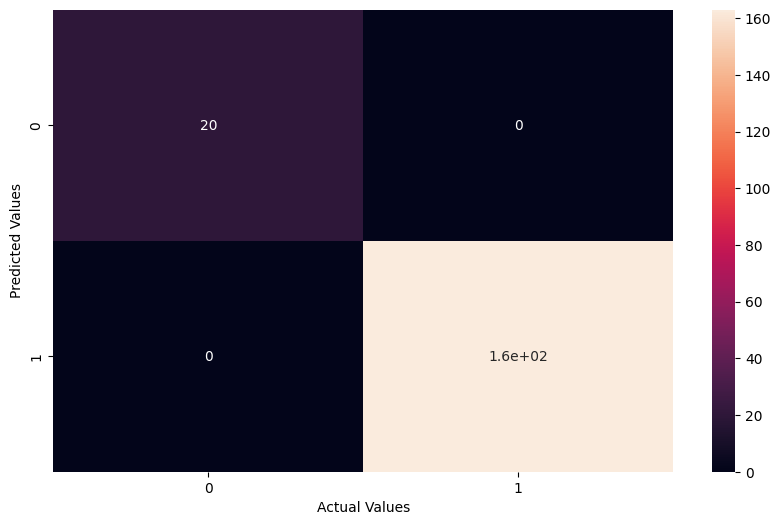

1.0


In [171]:
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.2)
pipe1.fit(X_train,y_train)
pipe1.score(X_train,y_train)
pipe1.score(X_test,y_test)
y_pred=pipe1.predict(X_test)
cMatrix()

decided to do some model Interpretation to see what is going on and why the accuracy is so suspiciously high

##Model Interpretation

Permutation explainer: 184it [01:06,  2.28it/s]


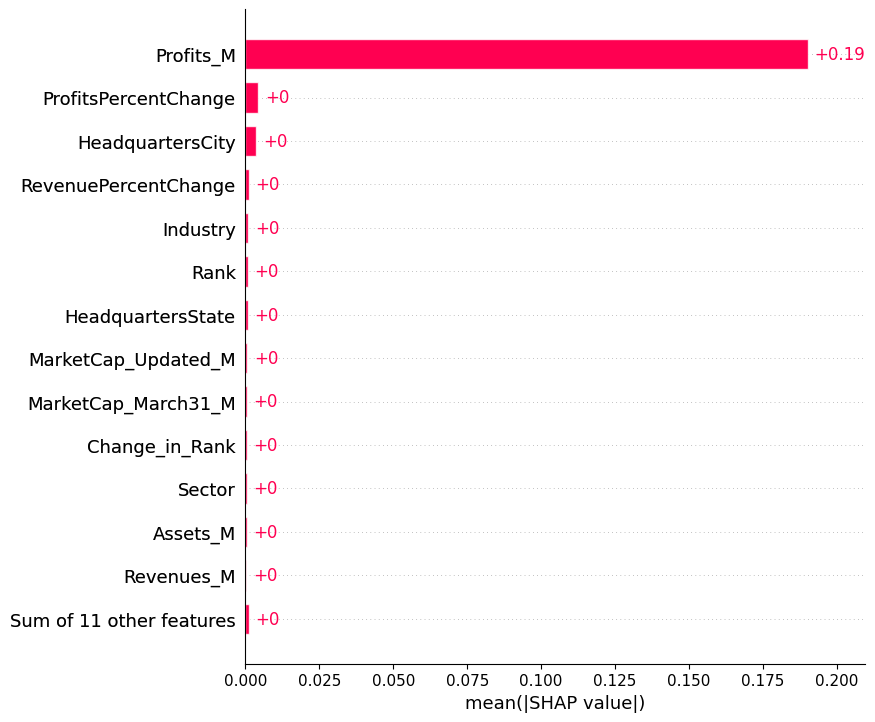

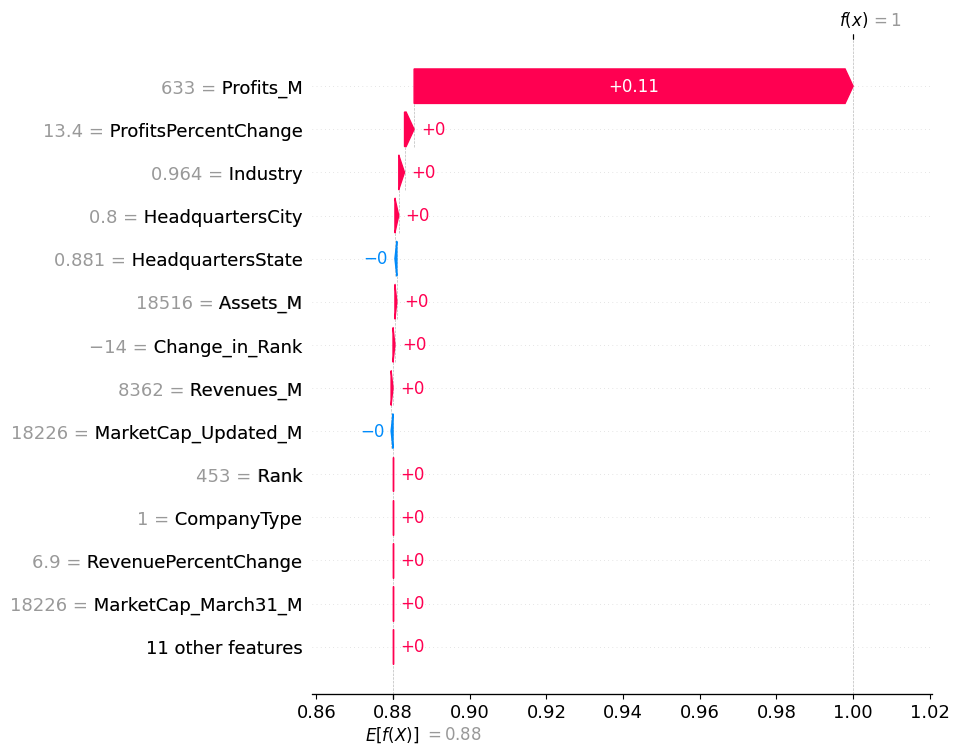

In [172]:
import shap
shap.initjs()
pipe1.fit(X_train,y_train)
explainer = shap.Explainer(pipe1.predict, X_train,
feature_names = list(df.columns).remove("Profitable"))
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=14)
shap.plots.waterfall(shap_values[0], max_display=14)


##Conclusion

only Profits_M, everything else is 0, i think i see where this is going

In [173]:
train=df["Profits_M"]
test=df["Profitable"]
X_train,X_test,y_train,y_test=train_test_split(train,test,test_size=0.2)

with only the column Profits_M we got an accuracy of 100%, unbelivable

In [174]:
lr.fit(np.array(X_train).reshape(-1,1), y_train)
lr.score(np.array(X_test).reshape(-1,1),y_test)

1.0

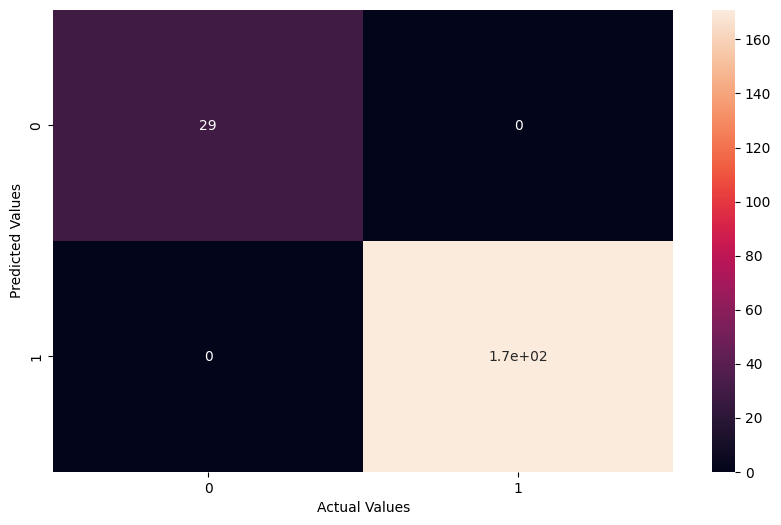

1.0


In [175]:
y_pred=lr.predict(np.array(X_test).reshape(-1,1))
cMatrix()

final check, just needed to visualise the actual data, and what do we see...

<Axes: xlabel='Profits_M', ylabel='Count'>

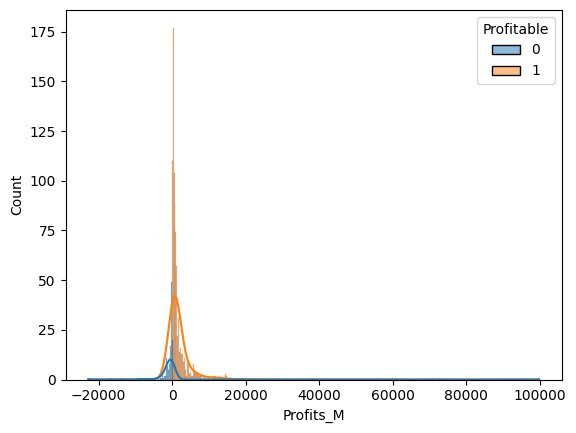

In [176]:
sns.histplot(df, x='Profits_M', hue="Profitable",kde=True)

our model is pretty much like this:


In [177]:
def check(X):
  pred=[]
  for i in X:
    if i <=0:
      pred.append(0)
    else :
      pred.append(1)
  return pred

and thats exactly a 100% accuracy

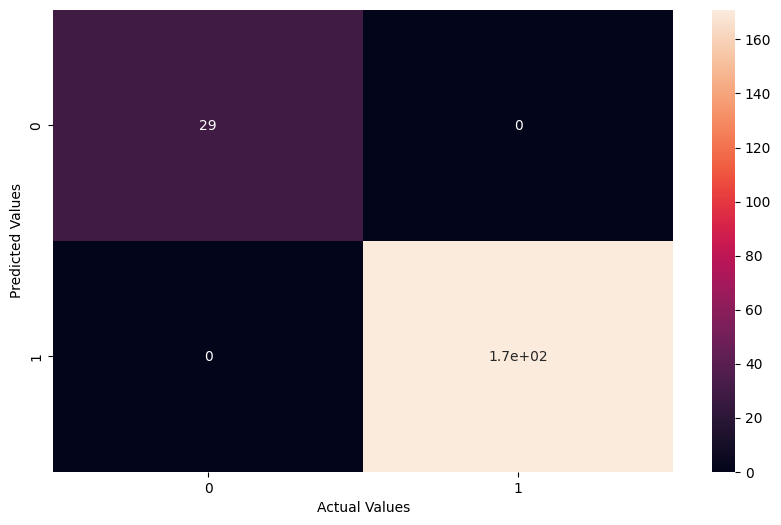

1.0


In [178]:
y_pred=check(X_test)
cMatrix()

In conclusion, this dataset that seemed to be quite difficult at the start because of a lot of problems intertwining, like 5 different columns that were quite unbalanced, yes thats their distribution, but it was quite strange. Turned out to be actually easy to reach, should one pay attention to some details. Yes it does make sense that a company is profitable if its Profits are >0 indeed.


  

  


  



#I lied







you thought that was it? me too, but I got bored so I decided to drop Profits_M

In [179]:
df=df.drop(["Profits_M"],axis=1)

Made a pipeline with just random forrest classifier to see how it goes

In [180]:
pipe1=Pipeline([

             ("Random Forrest", RandomForestClassifier()),
             ])

we get an accuracy of 82.7%, very good

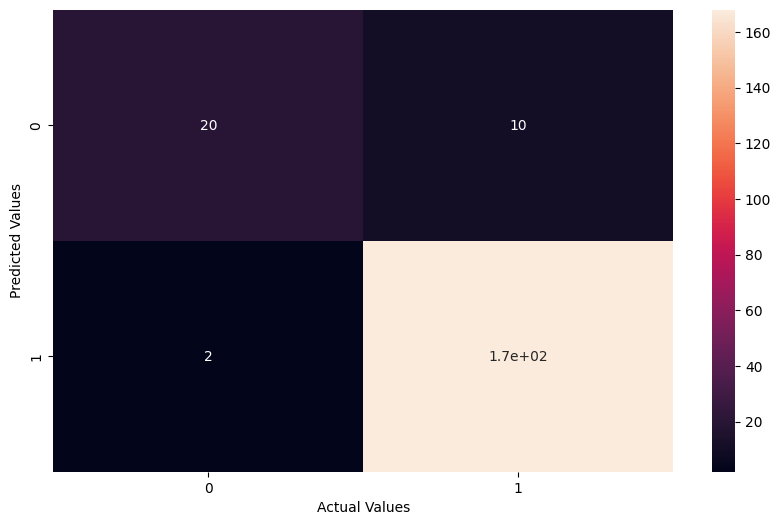

0.8274509803921568


In [181]:
X=df.drop(["Profitable"],axis=1)
y=df.Profitable

X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.2)
pipe1.fit(X_train,y_train)
pipe1.score(X_train,y_train)
pipe1.score(X_test,y_test)
y_pred=pipe1.predict(X_test)
cMatrix()

decided to do some more model interpretation and see what changed if there is no Profits_M. clearly now other collumns impact the target, this looks much more like a proper model.

Permutation explainer: 201it [01:24,  2.07it/s]


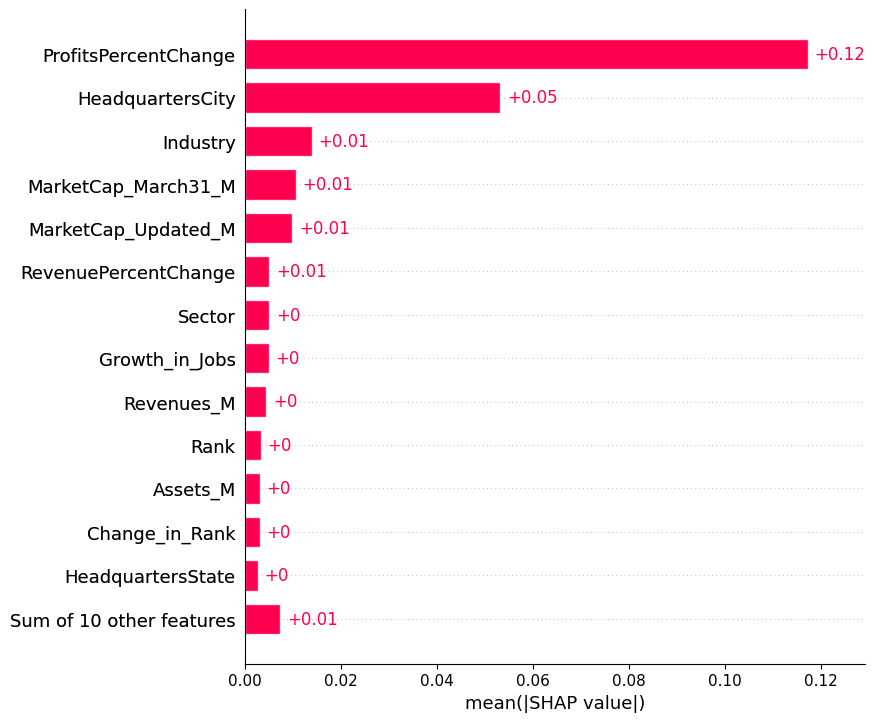

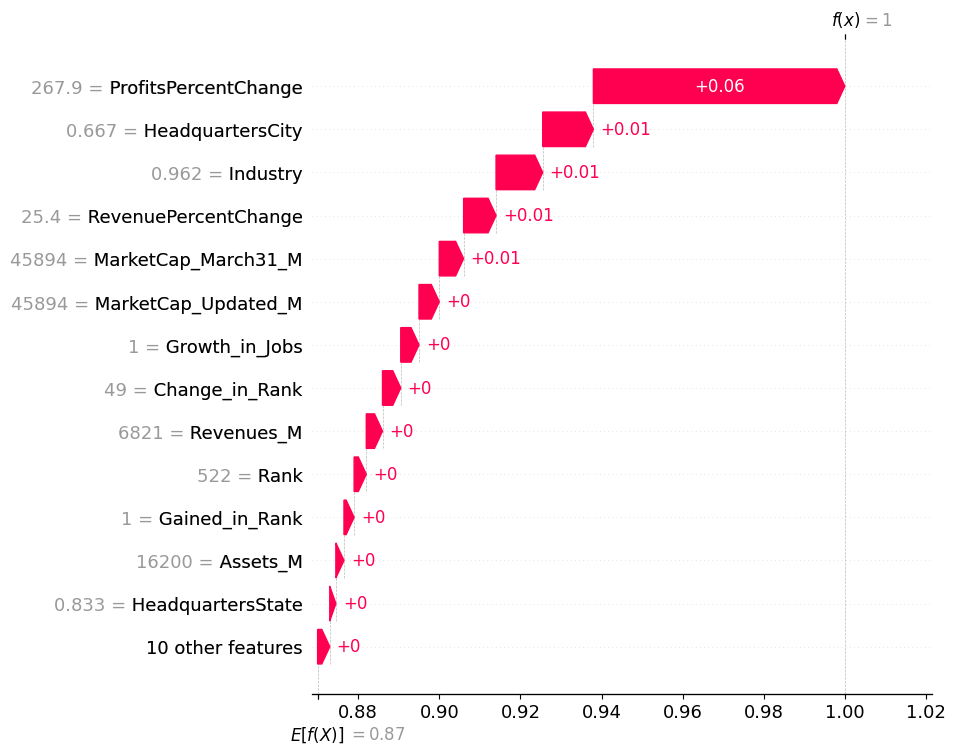

In [182]:
import shap
shap.initjs()
pipe1.fit(X_train,y_train)
explainer = shap.Explainer(pipe1.predict, X_train,
feature_names = list(df.columns).remove("Profitable"))
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=14)
shap.plots.waterfall(shap_values[0], max_display=14)


decided to do everything possible to improve the model, box cox transform, xgboost classifier, and isolation forest.

##BoxCoxTransformer,XGBoost

In [183]:
pipe1=Pipeline([
              ("BOX COX", BoxCoxTransformer()),
             ("XGBoost", XGBClassifier()),

             ])

In [184]:
isol=IsolationForest()
df_clean=df.copy()
df_clean["outlier"]=pd.Series(isol.fit_predict(df_clean.values))
df_clean=df_clean[df_clean.outlier!=-1]
df_clean.drop("outlier",axis=1,inplace=True)

we get an accuracy of 88%, based on experience I assmuned that the problem lied in BoxCoxTransform, it did not really help

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt


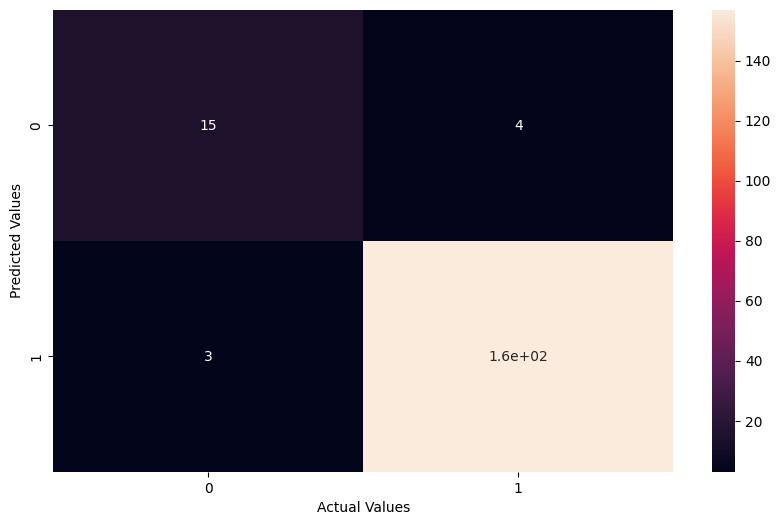

0.8853618421052631


In [185]:
X=df_clean.drop(["Profitable"],axis=1)
y=df_clean.Profitable

X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.2)
pipe1.fit(X_train.values,y_train)
pipe1.score(X_train.values,y_train)
pipe1.score(X_test.values,y_test)
y_pred=pipe1.predict(X_test.values)
cMatrix()

In [186]:
pipe1=Pipeline([
              # ("BOX COX", BoxCoxTransformer()),
             ("XGBoost", XGBClassifier()),

             ])

In [187]:
isol=IsolationForest()
df_clean=df.copy()
df_clean["outlier"]=pd.Series(isol.fit_predict(df_clean.values))
df_clean=df_clean[df_clean.outlier!=-1]
df_clean.drop("outlier",axis=1,inplace=True)

without BoxCoxTransform, We get an accuracy of 87.7% Which I consider to be a good result considering I dropped the collumn that gives the exact answer

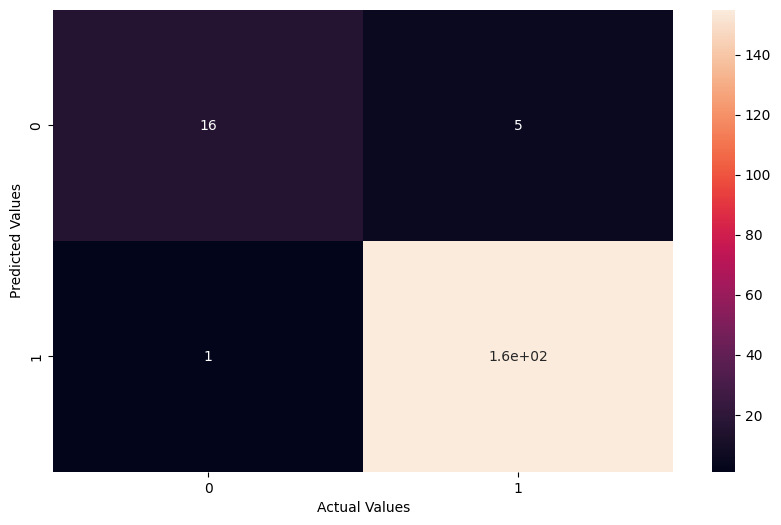

0.8777472527472527


In [188]:
X=df_clean.drop(["Profitable"],axis=1)
y=df_clean.Profitable

X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.2)
pipe1.fit(X_train.values,y_train)
pipe1.score(X_train.values,y_train)
pipe1.score(X_test.values,y_test)
y_pred=pipe1.predict(X_test.values)
cMatrix()

I decided to step it up a little and do some Hyperparameter tuning, we get an accuracy of 97.8% good.

##HyperParameter Tuning

In [189]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_classifier = xgb.XGBClassifier()

param_grid = {
    'booster': ['gbtree', 'gblinear'],  # 'gbtree' for tree-based, 'gblinear' for linear models
    'eta': [0.1, 0.2, 0.3],           # Learning rate (step size shrinkage)
    'gamma': [0, 1, 2],               # Minimum loss reduction required for further partition
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],  # Tree construction method
}

grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
    )

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_

test_score = best_xgb_model.score(X_test, y_test)
print("Test Set Score:", test_score)


Best Parameters: {'booster': 'gbtree', 'eta': 0.1, 'gamma': 0, 'tree_method': 'hist'}
Best Score: 0.9802517231045851
Test Set Score: 0.9774011299435028


Some final model interpretation, we can see the way each collumn has impacted the final decision, personally I found it slightly intriguing that Headquarters city had that high of an impact. also I found it interesting how this graph changed from one model to another.

Permutation explainer: 178it [00:22,  4.36it/s]


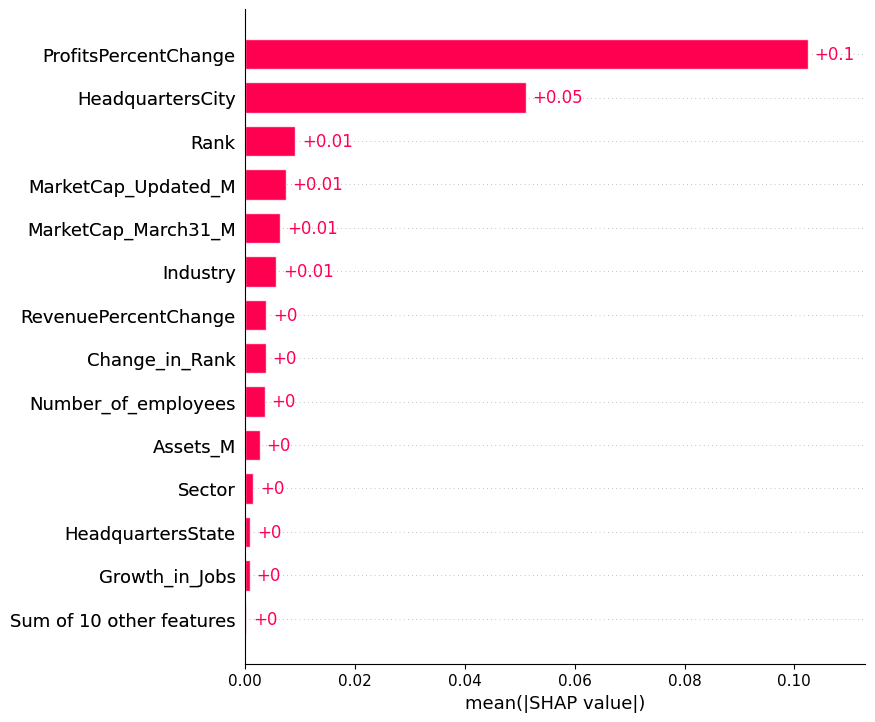

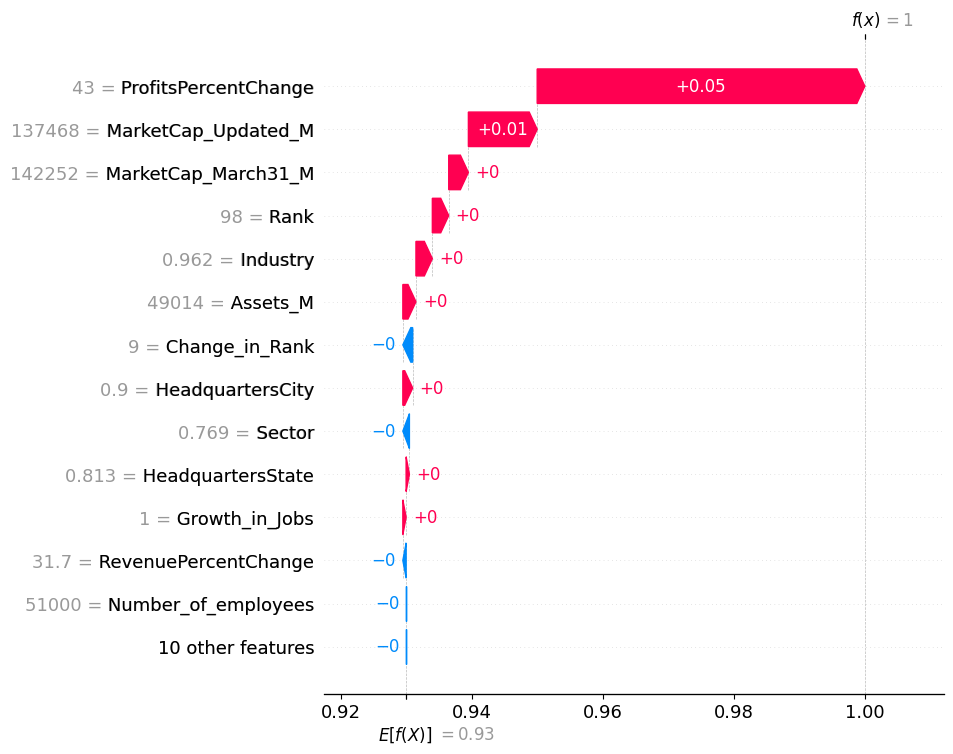

In [190]:
import shap
shap.initjs()
best_xgb_model.fit(X_train,y_train)
explainer = shap.Explainer(best_xgb_model.predict, X_train,
feature_names = list(df.columns).remove("Profitable"))
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=14)
shap.plots.waterfall(shap_values[0], max_display=14)


##PValue Selector

decided to try the model with PvalueSelector

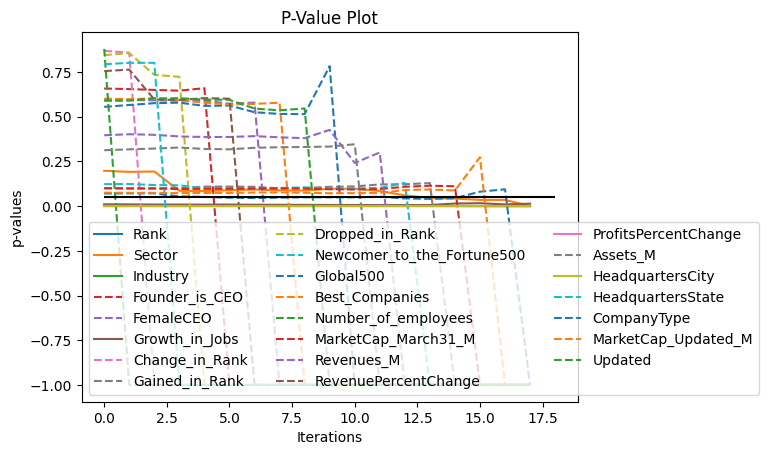

In [191]:
from kydavra import PValueSelector
pvalue_selector = PValueSelector()
selected_columns = pvalue_selector.select(df_clean, 'Profitable')
pvalue_selector.plot_process()


In [192]:
df_new=df_clean[selected_columns]

we get an accuracy of 86.8%

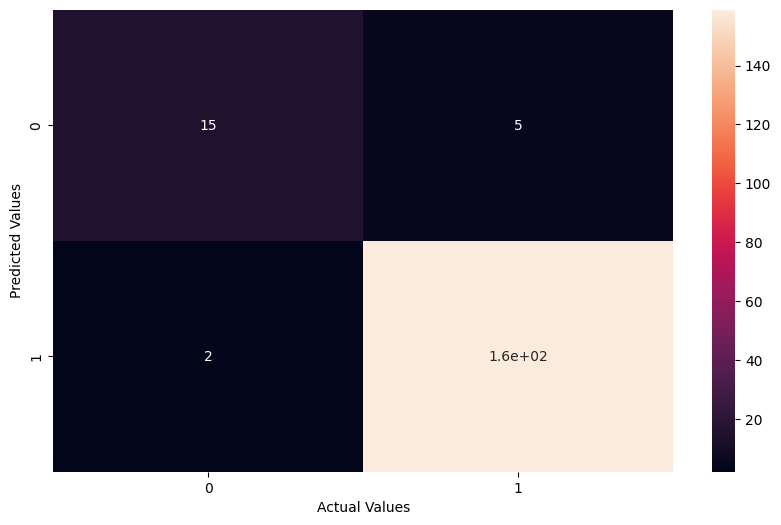

0.8687888198757764


In [193]:
pipe1=Pipeline([
              # ("BOX COX", BoxCoxTransformer()),
             ("XGBoost", XGBClassifier()),

             ])
isol=IsolationForest()
df_new=df.copy()
df_new["outlier"]=pd.Series(isol.fit_predict(df_new.values))
df_new=df_new[df_new.outlier!=-1]
df_new.drop("outlier",axis=1,inplace=True)

X=df_new.drop(["Profitable"],axis=1)
y=df_new.Profitable

X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.2)
pipe1.fit(X_train.values,y_train)
pipe1.score(X_train.values,y_train)
pipe1.score(X_test.values,y_test)
y_pred=pipe1.predict(X_test.values)
cMatrix()

and 97.2% with HyperParameter Tuning, worse than without PvalueSelector

In [194]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_classifier = xgb.XGBClassifier()

param_grid = {
    'booster': ['gbtree', 'gblinear'],  # 'gbtree' for tree-based, 'gblinear' for linear models
    'eta': [0.1, 0.2, 0.3],           # Learning rate (step size shrinkage)
    'gamma': [0, 1, 2],               # Minimum loss reduction required for further partition
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],  # Tree construction method
}

grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
    )

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_

test_score = best_xgb_model.score(X_test, y_test)
print("Test Set Score:", test_score)


Best Parameters: {'booster': 'gbtree', 'eta': 0.2, 'gamma': 2, 'tree_method': 'auto'}
Best Score: 0.9820210727969348
Test Set Score: 0.9723756906077348


In [196]:
li=[]
lr=best_xgb_model

for i in range(1, X.shape[1]):
  pc=PCA(i).fit(X)
  X_pc=pc.transform(X)
  X_train, X_test, y_train, y_test=train_test_split(X_pc, y, test_size=0.2, random_state=19)
  lr.fit(X_train, y_train)
  li.append(lr.score(X_test, y_test))
highest=max(li)
i1=li.index(highest)
lowest=min(li)
i2=li.index(lowest)
print(f"highest accuracy reached at: {highest},with {i1+1} components")
print(f"lowest accuracy reached at: {lowest},with {i2+1} components")

highest accuracy reached at: 0.9668508287292817,with 17 components
lowest accuracy reached at: 0.8784530386740331,with 2 components


##Final conclusion

Finally we have reached the end, to sum things up, I got two results, one 100% model which was achieved by 'underhanded means' since I pretty much has the answer from the start,

and an 97.8% accuracy model which was built using proper means. this is a much better result.